In [35]:
%matplotlib inline

import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import bayes_net_utils as bn

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

plt.style.use('ggplot')

# Introduction

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Predict_with_BN.ipynb and either compares predictions produced using different kinds of met data, or compares predictions to observations from the lake. 

In [36]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_era5_fpath = '../Data/Predictions/Historic/GBN_prediction_era5_1981-2019.csv'
sim_metno_fpath = '../Data/Predictions/Historic/GBN_prediction_metno_1981-2018.csv'
sim_era5_av_fpath = '../Data/Predictions/Historic/GBN_prediction_era5-av_1981-2019.csv'
sim_s5_folder = '../Data/Predictions/Historic/s5'
sim_naive_fpath = '../Data/Predictions/Historic/Prediction_naive_1981-2019.csv'

out_folder = '../Hindcast_stats_plots'

var_list = ['TP','chla','colour','cyano']

# Read in data and reformat

## Observations

In [37]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# Reformat obs to long format, same as the others
obs = pd.melt(obs_wide, id_vars=['year'], value_vars=var_list,
         var_name='node', value_name='obs')

obs.tail()

,year,node,obs
151,2015,cyano,0.233
152,2016,cyano,0.166
153,2017,cyano,0.258
154,2018,cyano,0.614
155,2019,cyano,0.592


In [38]:
# Classify the observations

# Dictionary of thresholds to use. N.B. Also defined in bayes_net_utils.R (as boundaries_list)
boundaries_dict = {'TP': 29.5,     # Middle of 'Moderate' class
                   'chla': 20.0,   # M-P boundary. WFD boundaries: [10.5, 20.0]. Only 6 observed points under 10.5 so merge G & M
                   'colour': 48.0, # 66th percentile (i.e. upper tercile). No management implications
                   'cyano': 1.0    # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho
                  }

obs_disc = obs.copy()
obs_disc['obs'] = obs[['node','obs']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.obs), axis=1)
obs_disc.head()

,year,node,obs
0,1981,TP,0.0
1,1982,TP,0.0
2,1983,TP,1.0
3,1984,TP,0.0
4,1985,TP,1.0


## Seasonal naive prediction
i.e. prediction for the current season is the prediction for the previous (corresponding) season

In [39]:
# sim_naive_wide = pd.read_csv(sim_naive_fpath)

# # Reformat obs to long format, same as the others
# sim_naive = pd.melt(sim_naive_wide, id_vars=['year'], value_vars=var_list,
#             var_name='node', value_name='sim_naive')

# sim_naive_disc = sim_naive.copy()
# sim_naive_disc['sim_naive'] = sim_naive_disc[['node','sim_naive']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.sim_naive), axis=1)
# sim_naive_disc.head(2)

sim_naive = pd.read_csv(sim_naive_fpath)

# Pick out just the expected value
sim_naive_e = sim_naive[['year','node','expected_value']]
sim_naive_e.columns = ['year','node','sim_naive'] # Rename columns
display(sim_naive_e.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_naive_disc = sim_naive[['year','node','WFD_class']]
sim_naive_disc.columns = ['year','node','sim_naive']
display(sim_naive_disc.head(2))

,year,node,sim_naive
0,1981,TP,43.573016
1,1982,TP,28.833333


,year,node,sim_naive
0,1981,TP,1.0
1,1982,TP,0.0


## Predictions driven by ERA5 met data ('pseudo-observations')

In [40]:
# Read in predictions driven by ERA5 met data ('pseudoobs') and reformat to same format as obs
sim_era5 = pd.read_csv(sim_era5_fpath)

# Pick out just the expected value
sim_era5_e = sim_era5[['year','node','expected_value']]
sim_era5_e.columns = ['year','node','sim_era5'] # Rename columns
display(sim_era5_e.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_era5_class = sim_era5[['year','node','WFD_class']]
sim_era5_class.columns = ['year','node','sim_era5']
display(sim_era5_class.head(2))

# Predicted probability of being in the class
sim_era5_classprob = sim_era5[['year','node','prob_below_threshold']]
sim_era5_classprob.columns = ['year','node','sim_era5']
display(sim_era5_classprob.head(2))

,year,node,sim_era5
0,1981,chla,19.3
1,1981,colour,28.8


,year,node,sim_era5
0,1981,chla,0
1,1981,colour,0


,year,node,sim_era5
0,1981,chla,0.57
1,1981,colour,0.98


## Read in predictions with constant met variables

Predictions in which met variables are set constant at long-term averages observed in ERA5

In [41]:
# Read in predictions driven by long-term average ERA5 met data and reformat to same format as obs
sim_era5_av = pd.read_csv(sim_era5_av_fpath)

# Pick out just the expected value
sim_era5_av_e = sim_era5_av[['year','node','expected_value']]
sim_era5_av_e.columns = ['year','node','sim_era5_av'] # Rename columns
display(sim_era5_av_e.head(2))

# Discretized df, including the class prediction
sim_era5_av_class = sim_era5[['year','node','WFD_class']]
sim_era5_av_class.columns = ['year','node','sim_era5_av']
display(sim_era5_av_class.head(2))

# Predicted probability of being in the class
sim_era5_av_classprob = sim_era5[['year','node','prob_below_threshold']]
sim_era5_av_classprob.columns = ['year','node','sim_era5_av']
display(sim_era5_av_classprob.head(2))

,year,node,sim_era5_av
0,1981,chla,19.0
1,1981,colour,28.9


,year,node,sim_era5_av
0,1981,chla,0
1,1981,colour,0


,year,node,sim_era5_av
0,1981,chla,0.57
1,1981,colour,0.98


## Read in predictions driven by System5

In [42]:
# Read in BN predictions driven by s5 and reformat

member_li = ["%.2d" % i for i in range(1,26)] # List of S5 member numbers in format '01','02'... Should be present in s5 met data folder
season_li = ['summer', 'late_summer'] # Seasons of interest (must match filenames in s5 met data folder)
st_yr = 1993
end_yr = 2019

sim_s5_dict = {} # key: season, returns df with cols yr, node, expected values from member 01, 02, 03,...
sim_s5_class_dict = {} # key: season, returns df with cols yr, node, sim_s5_class_%s, where %s is member number

for season in season_li:
    
    expected_value_li = []
    classes_li = []
#     probs_li = []
    
    for member in member_li:

        # Read in predictions for this season and member
        s5fname = 'GBN_prediction_s5_%s-%s_%s_%s.csv' %(st_yr, end_yr, season, member)
        s5fpath = os.path.join(sim_s5_folder, s5fname)
        sim_s5 = pd.read_csv(s5fpath)
        
        # Extract just the expected value, rename, and add to list
        expected_values = sim_s5['expected_value']
        expected_values.name = 'sim_s5_%s' %member
        expected_value_li.append(expected_values)
        
        # Discretized df, including the class and the predicted probability of being in the class
        classes = sim_s5['WFD_class']
        classes.name = 'sim_s5_%s' %member
        classes_li.append(classes)
        
#         probs = sim_s5['prob_below_threshold']        
#         probs.name = 'sim_s5_prob_%s' %member
#         probs_li.append(probs)
    
    # Make dataframe of expected values and add to expected values dict for s5
    sim_s5_e = pd.concat([sim_s5[['year','node']]]+expected_value_li, axis=1)
    sim_s5_dict[season] = sim_s5_e
    
    # Make dataframe of discretized values and add to discretized dict for s5
    sim_s5_class = pd.concat([sim_s5[['year','node']]] + classes_li, axis=1)
    sim_s5_class_dict[season] = sim_s5_class

# Check of output
display(sim_s5_dict['summer'].head())
display(sim_s5_class_dict['summer'].head())

,year,node,sim_s5_01,sim_s5_02,sim_s5_03,sim_s5_04,sim_s5_05,sim_s5_06,sim_s5_07,sim_s5_08,...,sim_s5_16,sim_s5_17,sim_s5_18,sim_s5_19,sim_s5_20,sim_s5_21,sim_s5_22,sim_s5_23,sim_s5_24,sim_s5_25
0,1993,chla,14.60,14.50,15.60,17.00,15.90,16.90,17.00,16.40,...,16.60,17.20,15.40,17.00,13.900,17.80,16.50,16.50,17.80,15.30
1,1993,colour,23.80,23.50,23.80,22.40,30.40,22.00,22.80,24.10,...,23.80,22.60,25.60,24.70,24.500,19.60,22.80,21.20,25.20,27.10
2,1993,cyano,1.08,1.07,1.28,1.65,1.16,1.65,1.64,1.44,...,1.51,1.71,1.19,1.58,0.945,2.02,1.53,1.56,1.77,1.12
3,1993,TP,29.90,29.90,29.90,29.90,29.90,29.90,29.90,29.90,...,29.90,29.90,29.90,29.90,29.900,29.90,29.90,29.90,29.90,29.90
4,1994,chla,12.60,14.10,14.90,14.90,14.00,13.40,12.90,15.40,...,15.00,14.40,13.20,15.60,13.700,11.20,13.80,15.50,13.50,12.60


,year,node,sim_s5_01,sim_s5_02,sim_s5_03,sim_s5_04,sim_s5_05,sim_s5_06,sim_s5_07,sim_s5_08,...,sim_s5_16,sim_s5_17,sim_s5_18,sim_s5_19,sim_s5_20,sim_s5_21,sim_s5_22,sim_s5_23,sim_s5_24,sim_s5_25
0,1993,chla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1993,colour,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1993,cyano,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
3,1993,TP,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1994,chla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Calculate quantiles of interest of s5 from the expected values of the 25 members
s5_quant_dict = {} # Key season, returns df with year, node, quantiles (0.025, 0.5, 0.975)
for season in season_li:
    s5_val_cols = sim_s5_dict[season].drop(['year','node'],axis=1).columns
    s5_quantiles = sim_s5_dict[season][s5_val_cols].quantile([0.025, 0.5, 0.975], axis=1).T
    s5_quantiles.columns = ['s5_%s_%s' %(str(i), season) for i in s5_quantiles]
    s5_quantiles[['year','node']] = sim_s5_dict[season][['year','node']]
    s5_quant_dict[season] = s5_quantiles
s5_quantiles.head()

,s5_0.025_late_summer,s5_0.5_late_summer,s5_0.975_late_summer,year,node
0,15.860,17.40,18.98,1993,chla
1,19.740,22.70,26.16,1993,colour
2,1.366,1.74,2.34,1993,cyano
3,29.900,29.90,29.90,1993,TP
4,11.780,13.40,15.04,1994,chla


In [44]:
# Also convert median predicted quantile to predicted class
s5med_class_dict = {} # key: season, returns df with cols year, node, classification of median of S5 simulation for that season

for season in season_li:
    s5_median_class = s5_quant_dict[season][['year','node','s5_0.5_%s' %season]].copy()
    s5_median_class.columns = ['year','node','s5_0.5_%s' %season]
    s5_median_class['s5_0.5_%s' %season] = s5_median_class[['node','s5_0.5_%s' %season]].apply(lambda x: bn.discretize([boundaries_dict[x.node]],
                                                                                                               x['s5_0.5_%s' %season]), axis=1)
    s5med_class_dict[season] = s5_median_class
    
s5med_class_dict['late_summer'].head()

,year,node,s5_0.5_late_summer
0,1993,chla,0
1,1993,colour,0
2,1993,cyano,1
3,1993,TP,1
4,1994,chla,0


## Merge observations and predictions from all kinds of model

In [45]:
def merge_model_predictions(df_list):
    df = df_list[0].copy().set_index(['year','node'])
    for i, new_df in enumerate(df_list):
        new_df = new_df.set_index(['year','node'])
        if i>=1:
            df = df.join(new_df)
    df = df.reset_index()
    return df

In [46]:
# Make a dataframe of continuous data (expected values)

df_li = [obs, sim_era5_e, sim_era5_av_e, sim_naive_e, s5_quant_dict['summer'], s5_quant_dict['late_summer']]

df_cont = merge_model_predictions(df_li)
for season in season_li:
    df_cont = df_cont.drop(['s5_0.025_%s' %season,'s5_0.975_%s' %season], axis=1)

df_cont.tail()

,year,node,obs,sim_era5,sim_era5_av,sim_naive,s5_0.5_summer,s5_0.5_late_summer
151,2015,cyano,0.233,0.336,0.456,0.283,0.517,0.394
152,2016,cyano,0.166,0.442,0.514,0.233,0.501,0.457
153,2017,cyano,0.258,0.241,0.271,0.166,0.296,0.278
154,2018,cyano,0.614,0.421,0.452,0.258,0.453,0.578
155,2019,cyano,0.592,0.369,0.413,0.614,0.440,0.416


In [47]:
# Merge discretized timeseries into discretized dfs

df_class_list = [obs_disc,
                sim_naive_disc,
                s5med_class_dict['summer'],
                s5med_class_dict['late_summer'],
                sim_era5_class[['year','node','sim_era5']],
                sim_era5_av_class[['year','node','sim_era5_av']]]

# Also add classification of all members of S5?
# for member in member_li:
#     curr_df = sim_s5_class_dict['summer'][['year','node','sim_s5_%s' %member]]
#     curr_df.columns = ['year','node','sim_s5_%s' %member]
#     df_class_list.append(curr_df)
                
df_classes = merge_model_predictions(df_class_list)

df_classes.tail()

,year,node,obs,sim_naive,s5_0.5_summer,s5_0.5_late_summer,sim_era5,sim_era5_av
151,2015,cyano,0.0,0.0,0.0,0.0,0,0
152,2016,cyano,0.0,0.0,0.0,0.0,0,0
153,2017,cyano,0.0,0.0,0.0,0.0,0,0
154,2018,cyano,0.0,0.0,0.0,0.0,0,0
155,2019,cyano,0.0,0.0,0.0,0.0,0,0


In [48]:
# # Dataframe of probabilities of being in predicted class. This isn't available for observed or seasonal naive model

# df_prob_list = [
# #                 obs_disc,
# #                 sim_naive_disc,
#                 sim_era5_disc[['year','node','sim_era5_prob']],
#                 sim_era5_av_disc[['year','node','sim_era5_av_prob']]]
# for member in member_li:
#     curr_df = sim_s5_disc_dict['summer'][['year','node','sim_s5_prob_%s' %member]]
#     curr_df.columns = ['year','node','sim_s5_%s' %member]
#     df_prob_list.append(curr_df)
                
# #                 sim_s5_disc_dict['summer']]# sim_s5_disc_dict['late_summer']
# df_class_probs = merge_model_predictions(df_prob_list)

# df_class_probs.tail()

# Plot time series

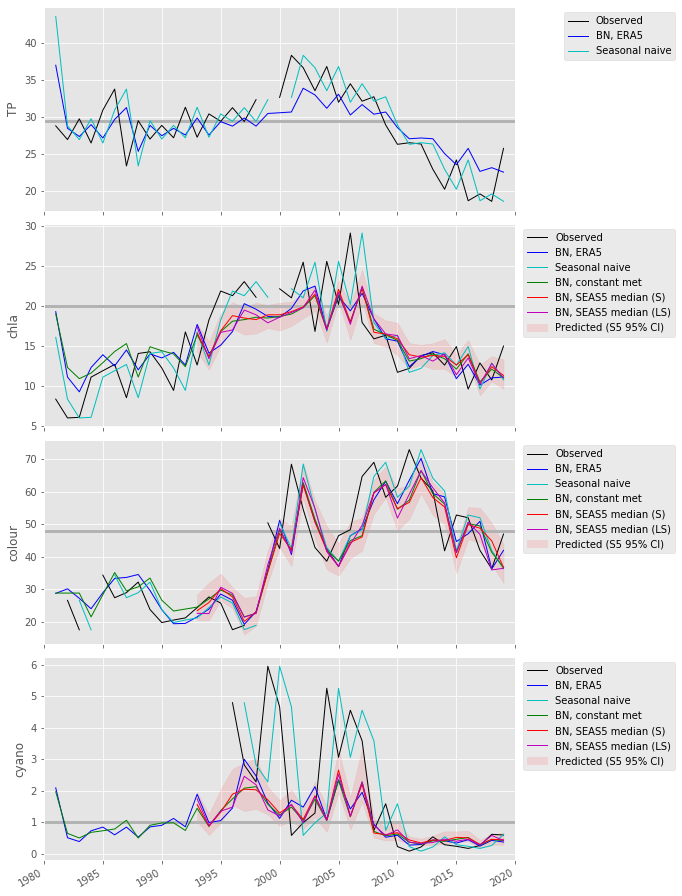

In [49]:
# Setup plot
fig, axes = plt.subplots(nrows=len(var_list), 
                         ncols=1, 
                         figsize=(10,15), 
                         sharex=True,
                        )

label_dict = {'obs':'Observed',
             'sim_era5':'BN, ERA5',
             'sim_naive':'Seasonal naive',
             'sim_era5_av':'BN, constant met',
             's5_0.5_summer': 'BN, SEAS5 median (S)',
             's5_0.5_late_summer': 'BN, SEAS5 median (LS)'}

colour_dict = {'obs':'k',
             'sim_era5':'b',
             'sim_naive':'c',
             'sim_era5_av':'g',
             's5_0.5_summer': 'r',
             's5_0.5_late_summer': 'm'}

# Loop over vars
for idx, var in enumerate(var_list):
    
    # Add WFD boundaries
    axes[idx].axhline(y=boundaries_dict[var], color='0.7', lw=3)
    
    # Plot observations and predictions
    for col in label_dict.keys():
        if var == 'TP' and col not in ['obs','sim_era5','sim_naive']:
            pass
        else:
            var_series = df_cont.loc[df_cont['node'] == var, [col,'year']]
            var_series = var_series.set_index('year')

            axes[idx].plot(var_series.index, 
                           var_series.values, 
                           color=colour_dict[col], 
                           lw=1, 
                           label=label_dict[col]
                          )
    if var != 'TP':
        # Plot S5 95% CI. N.B. CI for summe and late summer are ~exactly the same, so only plot one
        s5_quantiles = s5_quant_dict['summer'].loc[s5_quant_dict['summer']['node'] == var]
        s5_quantiles = s5_quantiles.set_index('year')
        axes[idx].fill_between(s5_quantiles.index, 
                               s5_quantiles['s5_0.025_summer'], 
                               s5_quantiles['s5_0.975_summer'], 
                               color='r', 
                               alpha=0.1,
                               label='Predicted (S5 95% CI)',
                              )
    
    # Tidy
    axes[idx].set_ylabel(var)
    axes[idx].set_xlim(xmin=1980, xmax=2020)
    axes[idx].legend(bbox_to_anchor=(1.35, 1))
    
plt.tight_layout()
fig.autofmt_xdate()
plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_gof.png'), dpi=300)

Using long-term mean weather from ERA5 as a constant input to the model gives almost exactly as good a prediction (compared to lake obs) as S5-driven predictions. i.e. S5 (or ERA5, for that matter) is no better than long-term average climate for any of my simulated variables. The model/lake is just too insensitive to weather, and very driven by the condition of the lake the previous year (and other things which probably aren't included in the model). On the plus, I have pretty good seasonal forecasting ability. Well, it's a result of sorts I guess...! Plenty to discuss in a paper anyway.

# Goodness of fit statistics: simulated vs observed

## Define functions to calculate continuous and discrete GoF stats

In [50]:
def gof_stats(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2019):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest
    Input:
        df: with columns 'year', 'node' (variable), 'obs', predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats    
    """
    gof_df_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        cc_li = []
        cc_sp_li = []
        mae_li = [] # mean absolute error
        rmse_li = []
        bias_li = []
        mape_li = [] # mean absolute % error
        
        for col in sim_cols_of_interest:
            
            df_test = df_var[[obs_col, col]].dropna()
            
            errors = df_test[col] - df_test[obs_col]
            
            cc = df_test[obs_col].corr(df_test[col], method='pearson')
            cc_sp = df_test[obs_col].corr(df_test[col], method='spearman')
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(((errors) ** 2)))
            bias = np.mean(errors)
            mape = np.mean(100*(errors/df_test[obs_col]))
            
            cc_li.append(cc)
            cc_sp_li.append(cc_sp)
            mae_li.append(mae)
            rmse_li.append(rmse)
            bias_li.append(bias)
            mape_li.append(mape)

        gof_df = pd.DataFrame(list(zip(cc_li, cc_sp_li, mae_li, rmse_li, bias_li, mape_li)),
                              columns = ['pearsons_cc','spearman_cc','mae','rmse','bias','mape'],
                              index = sim_cols_of_interest)

        gof_df_dict[var] = gof_df

    gof_df = pd.concat(gof_df_dict.values(), keys=gof_df_dict.keys())
    
    return gof_df

In [51]:
def gof_stats_classified_data(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2019):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest.
    See https://towardsdatascience.com/machine-learning-an-error-by-any-other-name-a7760a702c4d for a description of stats calculated,
    as well as the sklearn documentation
    
    Input:
        df: with columns 'year', 'node' (variable), observed and predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats   
    """

    gof_df_disc_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        mcc_li = [] # Matthews correlation coefficient
        roc_li = [] # ROC
        ce_li = [] # Classification error

        for col in sim_cols_of_interest:
            
            test_df = df_var[[obs_col, col]].dropna()

            mcc = matthews_corrcoef(test_df[obs_col].values, test_df[col].values)
            rocs = roc_auc_score(test_df[obs_col].values, test_df[col].values)
            ce = bn.classification_error(test_df[obs_col], test_df[col])

            mcc_li.append(mcc)
            roc_li.append(rocs)
            ce_li.append(ce)

        gof_df = pd.DataFrame(list(zip(mcc_li,
                                       roc_li,
                                      ce_li)),
                              columns = ['mathews_cc',
                                        'roc_auc_score',
                                        'classification_error'],
                              index = sim_cols_of_interest)

        gof_df_disc_dict[var] = gof_df

    gof_class_df = pd.concat(gof_df_disc_dict.values(), keys=gof_df_disc_dict.keys())
    
    return gof_class_df

## Compare simulated to real lake data, period with overlapping data (1993-2019)

In [52]:
obs_col = 'obs'
sim_cols = list(label_dict.keys())[1:] # i.e. all but observations
st_yr = 1993

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2019.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df

pearsons_cc  spearman_cc       mae       rmse  \
var    model                                                               
TP     sim_era5               0.828426     0.848101  2.750594   3.396087   
       sim_naive              0.825191     0.841538  2.805400   3.297207   
       sim_era5_av            0.828426     0.848101  2.750594   3.396087   
       s5_0.5_summer          0.829981     0.849667  2.742902   3.386997   
       s5_0.5_late_summer     0.829981     0.849667  2.742902   3.386997   
chla   sim_era5               0.644521     0.652650  3.248380   4.072810   
       sim_naive              0.554488     0.616923  3.791726   4.802344   
       sim_era5_av            0.618034     0.664728  3.359533   4.194930   
       s5_0.5_summer          0.612453     0.653215  3.371071   4.170417   
       s5_0.5_late_summer     0.562341     0.604651  3.628763   4.385000   
colour sim_era5               0.791178     0.699145  7.611544   9.665330   
       sim_naive              0.787763     0.704615  8.244180  10.133530   
       sim_era5_av            0.770466     0.692991  7.895244   9.982697   
       s5_0.5_summer          0.771603     0.686154  7.985903  10.073724   
       s5_0.5_late_summer     0.776901     0.721026  8.013615   9.967194   
cyano  sim_era5               0.524906     0.687826  1.111742   1.792260   
       sim_naive              0.563204     0.715415  1.192313   1.759581   
       sim_era5_av            0.624364     0.745379  1.075658   1.768410   
       s5_0.5_summer          0.631419     0.726087  1.072075   1.736922   
       s5_0.5_late_summer     0.550574     0.731304  1.078825   1.802418   

                               bias       mape  mathews_cc  roc_auc_score  \
var    model                                                                
TP     sim_era5           -0.208966   1.459433    0.535714       0.767857   
       sim_naive           0.233714   1.586362    0.438719       0.720779   
       sim_era5_av        -0.208966   1.459433    0.535714       0.767857   
       s5_0.5_summer      -0.216658   1.425977    0.535714       0.767857   
       s5_0.5_late_summer -0.216658   1.425977    0.535714       0.767857   
chla   sim_era5           -1.180834  -3.000855    0.216025       0.587500   
       sim_naive           0.113619   4.138884    0.652778       0.826389   
       sim_era5_av        -1.315450  -3.134902    0.216025       0.587500   
       s5_0.5_summer      -1.157757  -2.143882   -0.038069       0.487500   
       s5_0.5_late_summer -1.176988  -2.154846   -0.038069       0.487500   
colour sim_era5           -1.710143  -0.507980    0.308607       0.653846   
       sim_naive           0.228352   2.914384    0.442308       0.721154   
       sim_era5_av        -1.921681   0.339561    0.308607       0.653846   
       s5_0.5_summer      -2.463989  -0.993172    0.389249       0.692308   
       s5_0.5_late_summer -2.160143  -0.678525    0.462910       0.730769   
cyano  sim_era5           -0.764908  18.677633    0.752618       0.877622   
       sim_naive           0.182957  76.168015    0.564902       0.784615   
       sim_era5_av        -0.835742  21.757079    0.752618       0.877622   
       s5_0.5_summer      -0.792908  30.271964    0.752618       0.877622   
       s5_0.5_late_summer -0.806742  25.978405    0.832168       0.916084   

                           classification_error  
var    model                                     
TP     sim_era5                        0.230769  
       sim_naive                       0.280000  
       sim_era5_av                     0.230769  
       s5_0.5_summer                   0.230769  
       s5_0.5_late_summer              0.230769  
chla   sim_era5                        0.346154  
       sim_naive                       0.160000  
       sim_era5_av                     0.346154  
       s5_0.5_summer                   0.423077  
       s5_0.5_late_summer              0.423077  
colour sim_era5                        0.346154  
       si

## Simulated vs real lake, for whole period (so leave out S5)
For a better comparison of naive, ERA5 and ERA5-av predictions

In [53]:
obs_col = 'obs'
sim_cols = ['sim_era5','sim_naive','sim_era5_av']
st_yr = 1981

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2019.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df

pearsons_cc  spearman_cc       mae      rmse      bias  \
var    model                                                                 
TP     sim_era5        0.641662     0.652291  3.004066  3.668598 -0.047395   
       sim_naive       0.636465     0.639165  3.421504  4.387387  0.488460   
       sim_era5_av     0.641662     0.652291  3.004066  3.668598 -0.047395   
chla   sim_era5        0.642794     0.605712  3.306561  4.216025 -0.074580   
       sim_naive       0.647769     0.631105  3.613692  4.599624  0.058472   
       sim_era5_av     0.598643     0.570115  3.520813  4.408643 -0.062738   
colour sim_era5        0.854275     0.863063  6.723108  8.628664 -0.465637   
       sim_naive       0.849135     0.843249  7.294954  9.207931  0.844530   
       sim_era5_av     0.837884     0.847802  7.126172  9.092561 -0.379526   
cyano  sim_era5        0.524906     0.687826  1.111742  1.792260 -0.764908   
       sim_naive       0.563204     0.715415  1.192313  1.759581  0.182957   
       sim_era5_av     0.624364     0.745379  1.075658  1.768410 -0.835742   

                         mape  mathews_cc  roc_auc_score  classification_error  
var    model                                                                    
TP     sim_era5      1.664239    0.356177       0.675070              0.315789  
       sim_naive     2.625402    0.180477       0.590774              0.405405  
       sim_era5_av   1.664239    0.356177       0.675070              0.315789  
chla   sim_era5      8.121755    0.297755       0.614286              0.236842  
       sim_naive     5.053979    0.706349       0.853175              0.108108  
       sim_era5_av   9.518806    0.297755       0.614286              0.236842  
colour sim_era5      3.196318    0.449823       0.720736              0.250000  
       sim_naive     5.532723    0.550848       0.779762              0.212121  
       sim_era5_av   5.286948    0.449823       0.720736              0.250000  
cyano  sim_era5     18.677633    0.752618       0.877622              0.125000  
       sim_naive    76.168015    0.564902       0.784615              0.217391  
       sim_era5_av  21.757079    0.752618       0.877622              0.125000

## Comparison to period used for cyanobacterial CV (1996-2019)

In [54]:
obs_col = 'obs'
sim_cols = ['sim_era5','sim_era5_av','sim_naive','s5_0.5_summer','s5_0.5_late_summer']
st_yr = 1996

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2019.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df.loc['cyano']

,pearsons_cc,spearman_cc,mae,rmse,bias,mape,mathews_cc,roc_auc_score,classification_error
model,,,,,,,,,
sim_era5,0.524906,0.687826,1.111742,1.792260,-0.764908,18.677633,0.752618,0.877622,0.125000
sim_era5_av,0.624364,0.745379,1.075658,1.768410,-0.835742,21.757079,0.752618,0.877622,0.125000
sim_naive,0.563204,0.715415,1.192313,1.759581,0.182957,76.168015,0.564902,0.784615,0.217391
s5_0.5_summer,0.631419,0.726087,1.072075,1.736922,-0.792908,30.271964,0.752618,0.877622,0.125000
s5_0.5_late_summer,0.550574,0.731304,1.078825,1.802418,-0.806742,25.978405,0.832168,0.916084,0.083333


## Compare s5 to 'pseudoobservations'

Predictions driven by s5 versus predictions driven by ERA5 (i.e. assume ERA5 is perfect, and model is perfect, and just look at how the seasonal met forecast errors propagate through the model)

In [55]:
obs_col = 'sim_era5'
sim_cols = ['sim_era5_av','s5_0.5_summer','s5_0.5_late_summer']
st_yr = 1993

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_pseudoobs_%s-2019.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df

pearsons_cc  spearman_cc       mae      rmse  \
var    model                                                              
TP     sim_era5_av            1.000000     1.000000  0.000000  0.000000   
       s5_0.5_summer          0.999928     0.999847  0.007407  0.038490   
       s5_0.5_late_summer     0.999928     0.999847  0.007407  0.038490   
chla   sim_era5_av            0.966221     0.963042  0.825926  1.013428   
       s5_0.5_summer          0.954635     0.938159  0.925926  1.127436   
       s5_0.5_late_summer     0.971940     0.973741  0.685185  0.888403   
colour sim_era5_av            0.984638     0.973748  2.133333  2.648130   
       s5_0.5_summer          0.977401     0.965201  2.403704  3.227830   
       s5_0.5_late_summer     0.982898     0.971760  2.251852  2.659156   
cyano  sim_era5_av            0.944131     0.959243  0.186519  0.274651   
       s5_0.5_summer          0.932516     0.951770  0.204741  0.283669   
       s5_0.5_late_summer     0.966391     0.967033  0.155815  0.208878   

                               bias      mape  mathews_cc  roc_auc_score  \
var    model                                                               
TP     sim_era5_av         0.000000  0.000000    1.000000       1.000000   
       s5_0.5_summer      -0.007407 -0.027334    1.000000       1.000000   
       s5_0.5_late_summer -0.007407 -0.027334    1.000000       1.000000   
chla   sim_era5_av        -0.137037 -0.020607    1.000000       1.000000   
       s5_0.5_summer       0.029630  1.085503    0.741620       0.800000   
       s5_0.5_late_summer -0.025926  0.455890    0.741620       0.800000   
colour sim_era5_av        -0.222222  0.764732    1.000000       1.000000   
       s5_0.5_summer      -0.729630 -0.436585    0.775330       0.883333   
       s5_0.5_late_summer -0.451852 -0.355194    0.850000       0.925000   
cyano  sim_era5_av        -0.072370  0.614965    1.000000       1.000000   
       s5_0.5_summer      -0.031407  5.828900    1.000000       1.000000   
       s5_0.5_late_summer -0.035000  3.387306    0.928571       0.964286   

                           classification_error  
var    model                                     
TP     sim_era5_av                     0.000000  
       s5_0.5_summer                   0.000000  
       s5_0.5_late_summer              0.000000  
chla   sim_era5_av                     0.000000  
       s5_0.5_summer                   0.074074  
       s5_0.5_late_summer              0.074074  
colour sim_era5_av                     0.000000  
       s5_0.5_summer                   0.111111  
       s5_0.5_late_summer              0.074074  
cyano  sim_era5_av                     0.000000  
       s5_0.5_summer                   0.000000  
       s5_0.5_late_summer              0.037037

# Target plots (GoF stats summary)

In [56]:
# # sim_cols_of_interest = ['sim_era5','sim_naive','sim_era5_av','s5_0.5_summer']
# # st_yr = 1993

# sim_cols_of_interest = ['sim_era5','sim_naive','sim_era5_av']
# st_yr = 1982

# # Setup plot
# fig, axes = plt.subplots(nrows=len(var_list), ncols=len(sim_cols_of_interest), 
#                          figsize=(12, 12), 
#                          subplot_kw={'aspect':'equal'})

# for idx, var in enumerate(var_list):
    
#     df_var = df_cont.loc[df_cont['node']==var]
#     df_var = df_var.drop('node', axis=1).set_index('year')
#     df_var = df_var.loc[st_yr:,:]  

#     for idy, col in enumerate(sim_cols_of_interest):
#         title = f'{var}, {col}'
#         nivapy.plotting.target_plot(df_var['obs'], df_var[col],
#                                    ax = axes[idx, idy],
#                                    title = title)
        
#         # Turn off axes labels for now
#         ax = axes[idx, idy]
#         ax.yaxis.label.set_visible(False)
#         ax.xaxis.label.set_visible(False)

# plt.tight_layout()
# plt.savefig(os.path.join(out_folder,'target_plots_%s-2019.png' %st_yr), dpi=200)
# plt.show()

**Interpretation:**

For TP and cyano, my BN with constant met data does better than the seasonal naive forecast at classifying

# Time series for operational model

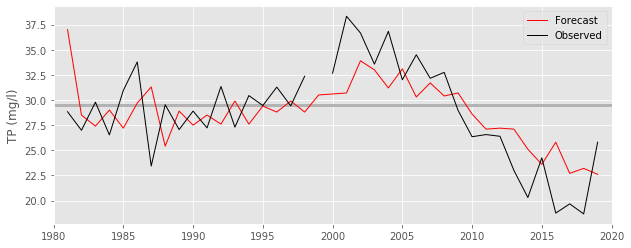

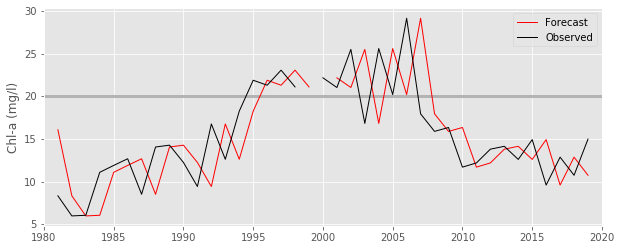

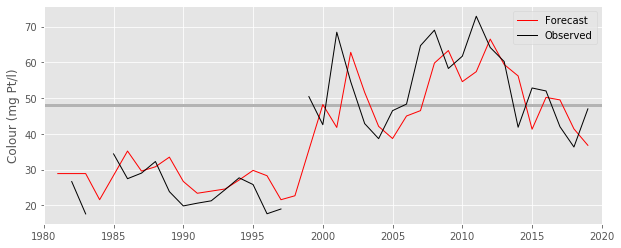

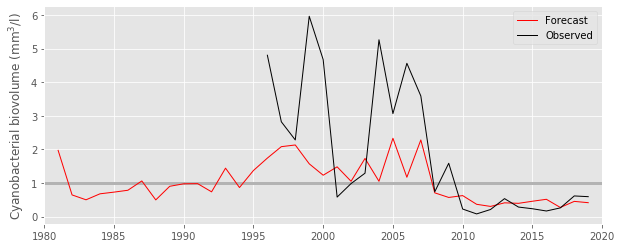

In [63]:
ylabel_dict = {'TP': 'TP (mg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacterial biovolume (mm$^3$/l)'}

# Loop over vars
for idx, var in enumerate(var_list):
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    
    # Add WFD boundary
    ax.axhline(y=boundaries_dict[var], color='0.7', lw=3)
    
    # Extract data
    
    # Forecasted
    if var != 'chla':
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_era5_av','year']]
    else:
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_naive','year']]
    forecasted = forecasted.set_index('year')
    
    # Observed
    obs = df_cont.loc[df_cont['node'] == var, ['obs','year']]
    obs = obs.set_index('year')
    
    # Plot forecast
    ax.plot(forecasted.index, 
            forecasted.values, 
            color='r',
            lw=1, 
            label='Forecast')
    
    # Plot observations
    ax.plot(obs.index,
           obs.values,
           color='k',
           lw=1,
           label='Observed')
    
    # Tidy
    ax.set_ylabel(ylabel_dict[var])
    ax.set_xlim(xmin=1980, xmax=2020)
    ax.legend()
    
    plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_operationalModel_%s.png' %var), dpi=150)